In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
import random

#print(tf.__version__)
# import seaborn as sns # haven't used yet - may want to use for pairplots

### Data Exploration

In [2]:
#read the data in as pandas df...

df = pd.read_csv('maize_major_yield.csv')
df_copied = df.copy()

# no empty cells - don't need to drop any exemplars
df_copied.isna().sum()

year                        0
jan rain                    0
jan mean min temperature    0
jan mean max temperature    0
feb rain                    0
feb mean min temperature    0
feb mean max temperature    0
mar rain                    0
mar mean min temperature    0
mar mean max temperature    0
apr rain                    0
apr mean min temperature    0
apr mean max temperature    0
may rain                    0
may mean min temperature    0
may mean max temperature    0
jun rain                    0
jun mean min temperature    0
jun mean max temperature    0
jul rain                    0
jul mean min temperature    0
jul mean max temperature    0
aug rain                    0
aug mean min temperature    0
aug mean max temperature    0
sep rain                    0
sep mean min temperature    0
sep mean max temperature    0
oct rain                    0
oct mean min temperature    0
oct mean max temperature    0
nov rain                    0
nov mean min temperature    0
nov mean m

#### Dropping outliers from the dataset

In [3]:
# if the variable value is 3 x std away from the mean then drop from the dataset

df_copy = df_copied[(np.abs(stats.zscore(df_copied)) < 3).all(axis=1)]

print(f'Number of exemplars before removing outliers: {len(df_copied)}')
print(f'Number of exemplars after removing outliers: {len(df_copy)}')
print(f'Number of exemplars removed: {len(df_copied) - len(df_copy)}')

Number of exemplars before removing outliers: 31744
Number of exemplars after removing outliers: 26498
Number of exemplars removed: 5246


## Data Visualisation

### Visualising yield against time

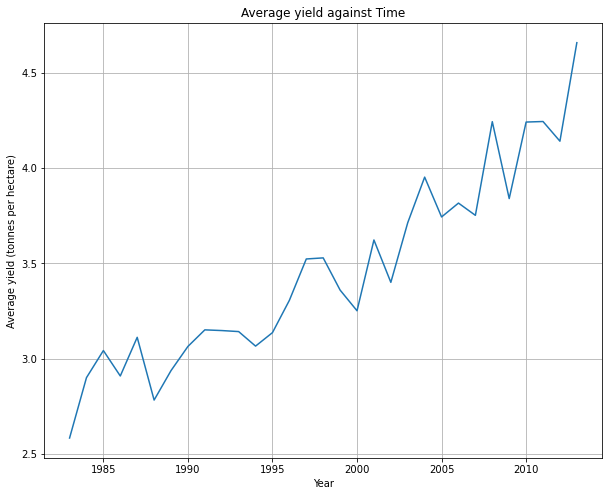

In [4]:
years = df_copy['year'].to_numpy()
unique_years = np.unique(years)

dic = dict()

#Collect all yields for each year...

for year in unique_years:
    yields = df_copy.loc[df_copy['year'] == year, 'yield']
    mean = yields.mean()
    dic[year] = mean
    
lists = sorted(dic.items()) # return a list of tuples
x, y = zip(*lists)

plt.figure(figsize=[10,8])
plt.grid(True)
plt.title('Average yield against Time')
plt.xlabel('Year')
plt.ylabel('Average yield (tonnes per hectare)')
plt.plot(x, y)
plt.show()

### Visualising Yield against Rainfall - 1983 & 2013

##### Assuming that rainfall is measured in mm

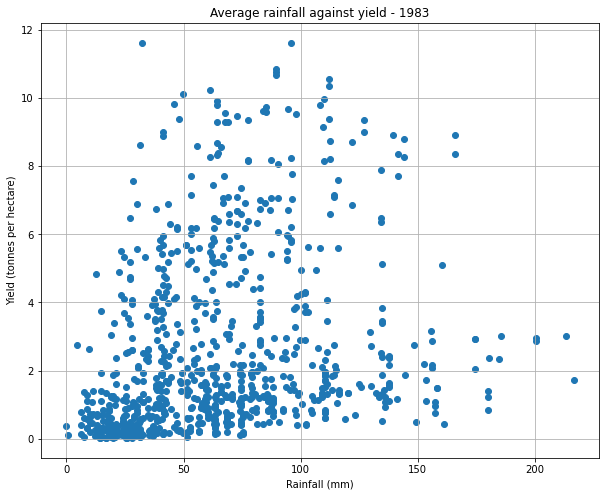

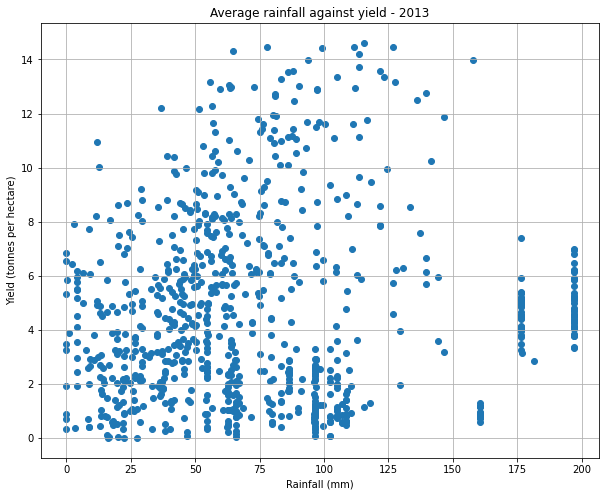

In [5]:
def wanted_variable(year, variable, mean = False):
    '''Function that looks at a particular year and selects the columns for a particular exemplar
    the criteria used to select the columns is the variable parameter
    If the mean parameter is set to True then calculate the mean of the selected columns'''
    
    wanted_year = df_copy.loc[df_copy['year'] == year]
    wanted_columns = wanted_year[wanted_year.columns[wanted_year.columns.to_series().str.contains(variable)]]
    yields = wanted_year['yield']
    
    if mean == True:
        average = wanted_columns.mean(axis=1)
        return average, yields
    else:
        return wanted_columns, yields
        
#the year 1983...
plt.figure(figsize=[10,8])
plt.grid(True)
plt.title('Average rainfall against yield - 1983')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Yield (tonnes per hectare)')
plt.scatter(wanted_variable(1983, 'rain', True)[0], wanted_variable(1983, 'rain', True)[1])
plt.show()

#the year 2013...
plt.figure(figsize=[10,8])
plt.grid(True)
plt.title('Average rainfall against yield - 2013')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Yield (tonnes per hectare)')
plt.scatter(wanted_variable(2013, 'rain', True)[0], wanted_variable(2013, 'rain', True)[1])
plt.show()

#### Less concentration around the origin, crops are able to produce higher yields at higher and lower levels of rainfall

### Visualising Yield against Temperature

##### Extreme weather conditions, below 5 degrees and above 30 degrees reduces growth - https://openweather.co.uk/blog/post/influence-temperature-plant-productivity-agriculture-accumulated-temperature#:~:text=Low%20(below%205%C2%B0C,C%20to%2025%C2%B0C.

In [6]:
#find the coldest and warmest months on average...

mini = wanted_variable(1983, ' mean min temperature')[0].mean(axis=0)
maxi = wanted_variable(1983, ' mean max temperature')[0].mean(axis=0)

#coldest month is december
print(mini)
print(mini.min())

#warmest month is july
print(maxi)
print(maxi.max())

jan mean min temperature     7.434120
feb mean min temperature     8.632704
mar mean min temperature    11.273908
apr mean min temperature    13.475089
may mean min temperature    15.466588
jun mean min temperature    16.768713
jul mean min temperature    17.979221
aug mean min temperature    17.854427
sep mean min temperature    16.484888
oct mean min temperature    13.800472
nov mean min temperature    11.104841
dec mean min temperature     7.365880
dtype: float64
7.365879574970477
jan mean max temperature    17.831405
feb mean max temperature    19.590201
mar mean max temperature    22.313223
apr mean max temperature    24.889492
may mean max temperature    27.210626
jun mean max temperature    28.405667
jul mean max temperature    29.624203
aug mean max temperature    29.448170
sep mean max temperature    28.638843
oct mean max temperature    25.570720
nov mean max temperature    22.498229
dec mean max temperature    17.893388
dtype: float64
29.624203069657547


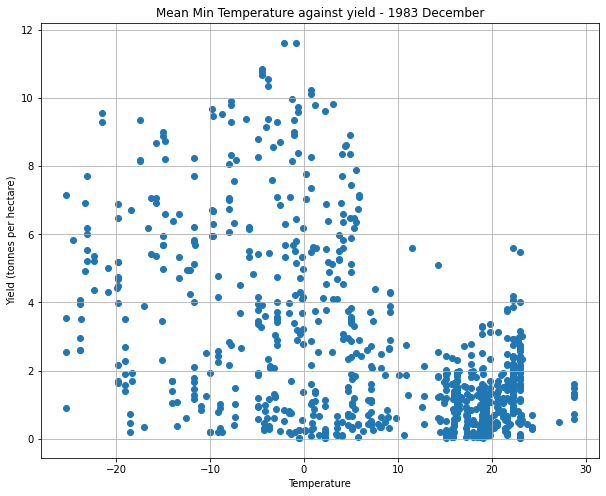

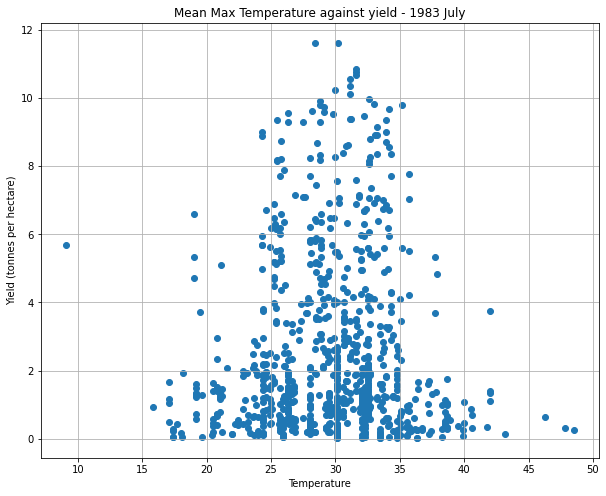

In [7]:
plt.figure(figsize=[10,8])
plt.grid(True)
plt.title('Mean Min Temperature against yield - 1983 December')
plt.xlabel('Temperature')
plt.ylabel('Yield (tonnes per hectare)')
plt.scatter(wanted_variable(1983, 'dec mean min temperature')[0], wanted_variable(1983, 'dec mean min temperature', True)[1])
plt.show()

plt.figure(figsize=[10,8])
plt.grid(True)
plt.title('Mean Max Temperature against yield - 1983 July')
plt.xlabel('Temperature')
plt.ylabel('Yield (tonnes per hectare)')
plt.scatter(wanted_variable(1983, 'jul mean max temperature')[0], wanted_variable(1983, 'jul mean max temperature', True)[1])
plt.show()

## Data Preparation

### Standardisation of the Data

In [8]:
#convert into numpy array...
df_np = df_copy.to_numpy()

#go through all elements in the list, effectively each column - not the year
for i in range(len(df_np[0])):
    #don't normalise the first column as it is a discrete time variable
    if i == 0:
        pass
    else:
        #calculate the mean and standard deviation...
        std = np.std(df_np[:,i])
        mean = np.mean(df_np[:,i])
        
        #substract the mean and divide by the standard deviation...
        df_np[:,i] = (df_np[:,i] - mean)/std

### PCA Reduction

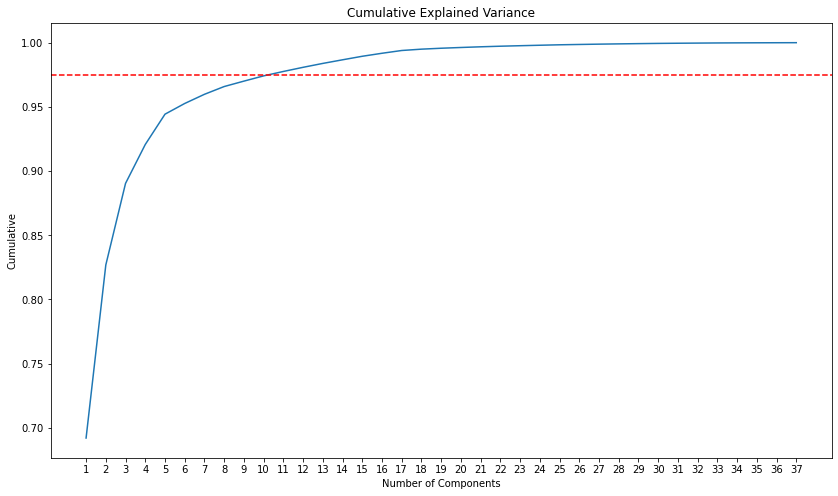

In [9]:
# remove the last element from each exemplar - remove target variable
np_df = df_np[:,:-1]

pca = PCA().fit(np_df.data)

plt.figure(figsize=(14,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of Components')
plt.ylabel('Cumulative');
plt.xticks(np.arange(np_df.shape[1]), np.arange(1, np_df.shape[1]+1))
plt.axhline(y=0.975, xmax=5,color='r', linestyle='--')
plt.title("Cumulative Explained Variance")
plt.show()

In [10]:
a = pca.explained_variance_ratio_
for i in range(1,37):
    ind = np.argpartition(a, -i)[-i:]
    summation = a[ind].sum()
    if summation >= 0.975:
        break

print(f'Number of components: {len(ind)}')
print(f'Variance Explained: {summation}')

Number of components: 11
Variance Explained: 0.9775848247671555


### Test, Train and Validation Splits - PCA Reduction included

In [11]:
# Reduce the number of components to 11 - based off previous cell...
pca = PCA(n_components = 11)
x_reduced = pca.fit_transform(np_df)
y = df_np[:,-1]

# Concatenate the matrices...
x_reduced_pd = pd.DataFrame(x_reduced)
y_pd = pd.DataFrame(y)
y_pd = y_pd.rename(columns = {0: 'yield'})

result = pd.concat([x_reduced_pd, y_pd], axis = 1)

# percentages, train, validation, test...
split_ratios = np.array([0.6, 0.2, 0.2])

# shuffle dataframe and create sets...
df = result.sample(frac = 1, random_state = 1453)

train_set, val_set, test_set = np.array_split(df, (split_ratios[:-1].cumsum() * len(df)).astype(int))

# size of each set
print('Validation set size:', val_set.shape[0])
print('Training set size:', train_set.shape[0])
print('Test set size:', test_set.shape[0])

Validation set size: 5300
Training set size: 15898
Test set size: 5300


### Features and Target Value splits

In [12]:
X_validate = val_set.drop('yield', axis = 1)
X_train = train_set.drop('yield', axis = 1)
X_test = test_set.drop('yield', axis = 1)

Y_validate = val_set['yield']
Y_train = train_set['yield']
Y_test = test_set['yield']

### Numpy Version of Datasets

In [13]:
X_val = val_set.drop('yield', axis = 1).to_numpy()
X_train = train_set.drop('yield', axis = 1).to_numpy()
X_test = test_set.drop('yield', axis = 1).to_numpy()

Y_val = val_set['yield'].to_numpy()
Y_train = train_set['yield'].to_numpy()
Y_test = test_set['yield'].to_numpy()

#### MSE Function

In [14]:
def MSE_function(Y, yhat):
    '''Function to calculate the MSE'''
    MSE = np.square(np.subtract(Y, yhat)).mean()
    MSE = round(MSE,5)
    
    return MSE

### Model 1 - Linear Regression

In [15]:
# analytical solution to regresion model...
#coefficients...
beta_hat = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(Y_train)

def predictions_linear(X, Y):
    yhat = X.dot(beta_hat)
    yhat = np.round(yhat,3)
    MSE = MSE_function(Y, yhat)

    return MSE

print(f'MSE value for training data: {predictions_linear(X_train, Y_train)}')
print(f'MSE value for test data: {predictions_linear(X_test, Y_test)}')

MSE value for training data: 0.62038
MSE value for test data: 0.59785


### Model 2 - Random Forest

In [16]:
# Build Regression Decision Tree

In [17]:
def calculate_var(y):
    '''Function to calculate the variance of y'''    
    var = np.var(y)    
    return var

print("The variance of 'y' is: {:.4f}".format(calculate_var(Y_train)))

The variance of 'y' is: 1.0093


In [18]:
def find_split(x, y, random_subspace):
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the lowest variance of the target variable.
    
    Uses random subspace method, randomly selects attributes for each feature"""
    start_var = calculate_var(y)
    best = {'variance' : start_var}
    
    # random subspace method...
    column_indices = list(range(x.shape[1]))
    random.seed(1453)
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(column_indices, random_subspace)
    
    # go through each unique value in that random subspace 
    for i in column_indices:
        for unique_value in np.unique(x[:,i]):
            #lhs & rhs features...
                       
            left_handside = y[x[:,i] <= unique_value]            
            no_lhs = len(left_handside)
                 
            right_handside = y[x[:,i] > unique_value]
            no_rhs = len(right_handside)
                        
            #weights...
            total_exemplars = no_lhs + no_rhs
            
            lhs_weight = no_lhs/total_exemplars
            rhs_weight = no_rhs/total_exemplars
            
            #variance of lhs ^ rhs            
            lhs_var = calculate_var(left_handside)
            rhs_var = calculate_var(right_handside)
            
            var = rhs_weight*rhs_var + lhs_weight*lhs_var        
                        
            left_array = np.where(x[:,i] <= unique_value)
                       
            left_indices = np.array(left_array)[0].tolist()
            
            right_array = np.where(x[:,i] > unique_value)
            right_indices = np.array(right_array)[0].tolist()
            
            if var < best['variance']:
                best = {'feature' : i,
                        'split' : unique_value,
                        'variance' : var, 
                        'left_indices' : left_indices,
                        'right_indices' : right_indices}
    
    return best

In [19]:
def find_split(x, y, random_subspace):
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the lowest variance of the target variable.
    
    Uses random subspace method, randomly selects attributes for each feature"""
    
    start_var = calculate_var(y)
    best = {'variance' : start_var}
    
    # random subspace method...
    column_indices = list(range(x.shape[1]))
    random.seed(1453)
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(column_indices, random_subspace)
    
    # go through each unique value in that random subspace 
    for i in column_indices:
        
        min_val = min(np.unique(x[:,i]))
        max_val = max(np.unique(x[:,i]))
        divider = 10
        length = len(np.unique(x[:,i]))
        
        # prevent rounding error - prevent 0 splits...
        no_splits = int(length / divider) + (length % divider > 0)
        splits = np.linspace(min_val, max_val, no_splits)
        
        for split in splits:
            #lhs & rhs features...
                       
            left_handside = y[x[:,i] <= split]            
            no_lhs = len(left_handside)
                 
            right_handside = y[x[:,i] > split]
            no_rhs = len(right_handside)
                        
            #weights...
            total_exemplars = no_lhs + no_rhs
            
            lhs_weight = no_lhs/total_exemplars
            rhs_weight = no_rhs/total_exemplars
            
            #variance of lhs ^ rhs            
            lhs_var = calculate_var(left_handside)
            rhs_var = calculate_var(right_handside)
            
            var = rhs_weight*rhs_var + lhs_weight*lhs_var        
                        
            left_array = np.where(x[:,i] <= split)
                       
            left_indices = np.array(left_array)[0].tolist()
            
            right_array = np.where(x[:,i] > split)
            right_indices = np.array(right_array)[0].tolist()
            
            if var < best['variance']:
                best = {'feature' : i,
                        'split' : split,
                        'variance' : var, 
                        'left_indices' : left_indices,
                        'right_indices' : right_indices}
    
    return best

In [20]:
def build_tree(x, y, random_subspace, max_depth = 2):
    '''Function to build branches of the tree by calling find_split function'''
    if max_depth==1 or (y==y[0]).all():
        # Generate a leaf node...
        mean = np.mean(y)
        rounded_mean = mean.round(3)

        return {'leaf' : True, 'prediction' : rounded_mean}
    
    else:
        move = find_split(x, y, random_subspace)
        
        left = build_tree(x[move['left_indices'],:], y[move['left_indices']], max_depth - 1, random_subspace)
        right = build_tree(x[move['right_indices'],:], y[move['right_indices']], max_depth - 1, random_subspace)
        
        return {'leaf' : False,
                'feature' : move['feature'],
                'split' : move['split'],
                'variance' : move['variance'],
                'left' : left,
                'right' : right}

In [21]:
# Bootstrapping...
def bootstrapped(X, Y, n_bootstrap):
    '''Function that randomly selects n_bootstrap no. of exemplars from a dataset'''
    np.random.seed(1453)
    bootstrap_indices = np.random.randint(0, len(X), n_bootstrap)
    X_boot = X[bootstrap_indices]
    Y_boot = Y[bootstrap_indices]
    
    return X_boot, Y_boot

In [22]:
# Random forest...

def random_forest(X, Y, n_trees, n_bootstrap, n_features, tree_max_depth = 5):
    '''Function that creates a forest using random subspace and bootstrapping'''
    forest = []
    for i in range(n_trees):
        X_boot, Y_boot = bootstrapped(X, Y, n_bootstrap)
        tree = build_tree(X_boot, Y_boot, max_depth = tree_max_depth, random_subspace = n_features)
        forest.append(tree)
        
    return forest

In [23]:
def predict(tree, samples):
    """Generalised function that takes a tree and sample as agruments and outputs 
    its predictions for every entry of a data matrix."""
    ret = np.empty(samples.shape[0], dtype=float)
    ret.fill(-1)
    indices = np.arange(samples.shape[0])
        
    def tranverse(node, indices):
        nonlocal samples
        nonlocal ret
        
        if node['leaf']:
            ret[indices] = node['prediction']
            
        else:
            going_left = samples[indices, node['feature']] <= node['split']
            left_indices = indices[going_left]
            right_indices = indices[np.logical_not(going_left)]
            
            if left_indices.shape[0] > 0:
                tranverse(node['left'], left_indices)
                
            if right_indices.shape[0] > 0:
                tranverse(node['right'], right_indices)
    
    tranverse(tree, indices)
    return ret

In [24]:
def forest_predict(forest, samples):
    '''Function to calculate the average prediction of all trees generated'''
    
    scores = []
    for tree in forest:
        score = predict(tree, samples)
        scores.append(score)
        
    predictions = np.mean(scores, axis = 0)
    
    return predictions

### Optimise hyperparameters

In [25]:
def forest_optimize():
    best_MSE = 1
    best_n_tree = None
    best_n_bootstrap = None
    best_n_features = None
    best_max_depth = None
    
    
    for i in range(5, 10):
        for j in range(2000, 5000, 150):
                    forest = random_forest(X_val, Y_val, 
                                   n_trees = i, 
                                   n_bootstrap = j,
                                   n_features = 1,
                                   tree_max_depth = 3)
                    predicting_validate = forest_predict(forest, X_val)
                    validate_MSE = MSE_function(Y_val, predicting_validate)
                    if validate_MSE < best_MSE:
                        best_MSE = validate_MSE
                        best_n_tree = i
                        best_n_bootstrap = j
                        best_n_features = 11
                        best_max_depth = 3
    
    return best_MSE, best_n_tree, best_n_bootstrap, best_n_features, best_max_depth

SyntaxError: invalid syntax (<ipython-input-25-a8fa9d114671>, line 14)

In [ ]:
def find_MSE(n_tree, n_bootstrap, n_features = 11, tree_max_depth = 3):
    '''Function that finds the MSE for the current random forest'''
    
    #create forest...
    forest = random_forest(X_val, Y_val, n_trees, n_bootstrap, n_features)
    
    #predict values using forest...
    predicting_validate = forest_predict(forest, X_val)
    
    #calculate MSE...
    validate_MSE = MSE_function(Y_val, predicting_validate)
    
    MSE_dic = {'Trees' : n_tree, 'Bootstrap' : n_bootstrap, 'MSE': validate_MSE}
    return MSE_dic

In [ ]:
forest = random_forest(X_val, Y_val, n_trees = 5, n_bootstrap = 5000, n_features = 11, tree_max_depth = 3)
predicting_validate = forest_predict(forest, X_val)
validate_MSE = MSE_function(Y_val, predicting_validate)
# validate_MSE



pool = Pool()
iteration 
pool.map(random_forest, iteration)

In [ ]:
best_MSE, best_n_tree, best_n_bootstrap, best_n_features, best_max_depth = forest_optimize()

# print('Hyperparameter tuning')
# print(f'Best number of trees {best_n_tree}')
# print(f'Best number of exemplars used in bootstrapping {best_n_bootstrap}')
# print(f'Best number of feartures in each tree {best_n_features}')
# print(f'Best max depth of each tree {best_max_depth}')

In [ ]:
def evaluate(X_train, Y_train, X_test, Y_test, n_trees = 7, n_bootstrap = 5000, n_features = 11, max_depth = 3):
    '''Function to evaluate how well the random forest does'''
    
    forest = random_forest(X_train, Y_train, n_trees, n_bootstrap, n_features, tree_max_depth = max_depth)

    predicting_train = forest_predict(forest, X_train)
    predicting_test = forest_predict(forest, X_test)
    
    train_MSE = MSE_function(Y_train, predicting_train)
    test_MSE = MSE_function(Y_test, predicting_test)
    
    return train_MSE, test_MSE

train_MSE, test_MSE = evaluate(X_train, Y_train, X_test, Y_test)
print('Train MSE: {:.2f}'.format(train_MSE))
print('Test MSE: {:.2f}'.format(test_MSE))

### Model 3 - Gaussian Proccess

### Model 4 - Neural Network

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
# Neural Network...
model = Sequential()

# 1st Hidden Layer...
model.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu'))

#2nd Hidden Layer...
model.add(Dense(64, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-10, 
                        patience=10, verbose=1, mode='auto', 
                        restore_best_weights=True)
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),
          callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
497/497 - 0s - loss: 0.5222 - val_loss: 0.4207
Epoch 2/1000
497/497 - 0s - loss: 0.4350 - val_loss: 0.4050
Epoch 3/1000
497/497 - 0s - loss: 0.4124 - val_loss: 0.3855
Epoch 4/1000
497/497 - 0s - loss: 0.3993 - val_loss: 0.3762
Epoch 5/1000
497/497 - 0s - loss: 0.3874 - val_loss: 0.3793
Epoch 6/1000
497/497 - 0s - loss: 0.3777 - val_loss: 0.3603
Epoch 7/1000
497/497 - 0s - loss: 0.3736 - val_loss: 0.3625
Epoch 8/1000
497/497 - 0s - loss: 0.3632 - val_loss: 0.3500
Epoch 9/1000
497/497 - 0s - loss: 0.3596 - val_loss: 0.3468
Epoch 10/1000
497/497 - 0s - loss: 0.3539 - val_loss: 0.3457
Epoch 11/1000
497/497 - 0s - loss: 0.3469 - val_loss: 0.3396
Epoch 12/1000
497/497 - 0s - loss: 0.3427 - val_loss: 0.3616
Epoch 13/1000
497/497 - 0s - loss: 0.3383 - val_loss: 0.3443
Epoch 14/1000
497/497 - 0s - loss: 0.3343 - val_loss: 0.3695
Epoch 15/1000
497/497 - 0s - loss: 0.3295 - val_loss: 0.3438
Epoch 16/1000
497/497 - 0s - loss: 0.3264 - val_loss: 0.3447
Epoch 17/1000
497/497 - 0s - loss

In [29]:
pred = model.predict(X_train)

#Measure MSE error

score = MSE_function(Y_train, pred)
print(f'MSE value of Neural Network: {score}')
from sklearn.metrics import r2_score

print(r2_score(Y_train, pred))

MSE value of Neural Network: 1.74464
0.7154012157353233
